In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

In [2]:



data_dir = "/kaggle/input/plantdisease/PlantVillage"


print(os.path.exists(data_dir))  


True


In [3]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),                 
    transforms.RandomResizedCrop(224),              
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomRotation(degrees=15),           
    transforms.ColorJitter(brightness=0.2,          
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1), 
    transforms.ToTensor(),                           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])


In [4]:

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Sizes
train_size = int(0.7 * len(dataset))  
val_size = int(0.1 * len(dataset))     
test_size = len(dataset) - train_size - val_size  

# Split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) #batch size=a rule of thumb in research

In [5]:


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        
        self.conv1_weight = nn.Parameter(torch.randn(16, 3, 3, 3) * 0.01)
        self.conv1_bias   = nn.Parameter(torch.zeros(16))
        self.conv2_weight = nn.Parameter(torch.randn(32, 16, 3, 3) * 0.01)
        self.conv2_bias   = nn.Parameter(torch.zeros(32))
        self.conv3_weight = nn.Parameter(torch.randn(64, 32, 3, 3) * 0.01)
        self.conv3_bias   = nn.Parameter(torch.zeros(64))
        
     
        self.fc1_weight = nn.Parameter(torch.randn(128, 64 * 28 * 28) * 0.01)
        self.fc1_bias   = nn.Parameter(torch.zeros(128))
        self.fc2_weight = nn.Parameter(torch.randn(num_classes, 128) * 0.01)
        self.fc2_bias   = nn.Parameter(torch.zeros(num_classes))
        
       
        self.dropout_p = 0.5


In [6]:
import torch.nn.functional as F

def forward(self, x):
   
    x = F.conv2d(x, self.conv1_weight, self.conv1_bias, stride=1, padding=1) 
    x = F.leaky_relu(x, negative_slope=0.01)  #to avoid dead  cell
    x = F.max_pool2d(x, 2, 2)
    
   
    x = F.conv2d(x, self.conv2_weight, self.conv2_bias, stride=1, padding=1)
    x = F.leaky_relu(x, negative_slope=0.01)  
    x = F.max_pool2d(x, 2, 2) #reduce 50% dimension
    
   
    x = F.conv2d(x, self.conv3_weight, self.conv3_bias, stride=1, padding=1)
    x = F.leaky_relu(x, negative_slope=0.01)   
    x = F.max_pool2d(x, 2, 2)
    
    
    x = x.view(-1, 64 * 28 * 28)
    
  
    x = F.linear(x, self.fc1_weight, self.fc1_bias)
    x = F.leaky_relu(x, negative_slope=0.01)  
    x = F.dropout(x, p=self.dropout_p, training=self.training)
    
    
    x = F.linear(x, self.fc2_weight, self.fc2_bias)
    return x


SimpleCNN.forward = forward


In [7]:
num_classes = len(dataset.classes)  # Number of disease categories
model = SimpleCNN(num_classes)
print(model)


SimpleCNN()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()       
optimizer = optim.Adam(model.parameters(), lr=0.001)  


In [9]:
lr = 0.001
num_epochs = 12
max_norm = 1.0

# Use standard PyTorch loss & optimizer
criterion = nn.CrossEntropyLoss()  # Combines softmax + log loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # --- Forward pass ---
        outputs = model(images)
        loss = criterion(outputs, labels)  # directly use labels
        
        # --- Backward pass ---
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    # --- Validation loop ---
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
    
    val_loss = val_running_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/12], Train Loss: 2.2206, Val Loss: 1.9503
Epoch [2/12], Train Loss: 1.8846, Val Loss: 1.6199
Epoch [3/12], Train Loss: 1.6585, Val Loss: 1.3831
Epoch [4/12], Train Loss: 1.5301, Val Loss: 1.3083
Epoch [5/12], Train Loss: 1.4303, Val Loss: 1.2540
Epoch [6/12], Train Loss: 1.3602, Val Loss: 1.1140
Epoch [7/12], Train Loss: 1.3160, Val Loss: 1.0924
Epoch [8/12], Train Loss: 1.2461, Val Loss: 1.1051
Epoch [9/12], Train Loss: 1.2064, Val Loss: 0.9998
Epoch [10/12], Train Loss: 1.1745, Val Loss: 1.0591
Epoch [11/12], Train Loss: 1.1268, Val Loss: 0.9220
Epoch [12/12], Train Loss: 1.0931, Val Loss: 0.9995


In [10]:
model.eval()  
correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%") #rafi


Test Accuracy: 67.21%


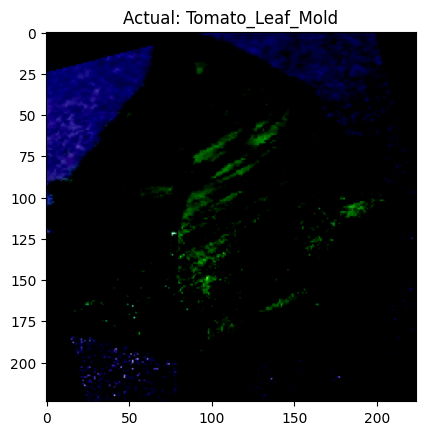

Predicted: Tomato__Tomato_mosaic_virus
20638


In [11]:



image_index = 111
image, label = test_dataset[image_index]


plt.imshow(image.permute(1, 2, 0))  
plt.title(f"Actual: {dataset.classes[label]}")
plt.axis('on')
plt.show()


image = image.unsqueeze(0).to(device)  


model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)#to ignore max value need max index

predicted_class = dataset.classes[predicted.item()]
print(f"Predicted: {predicted_class}")
print(len(dataset))


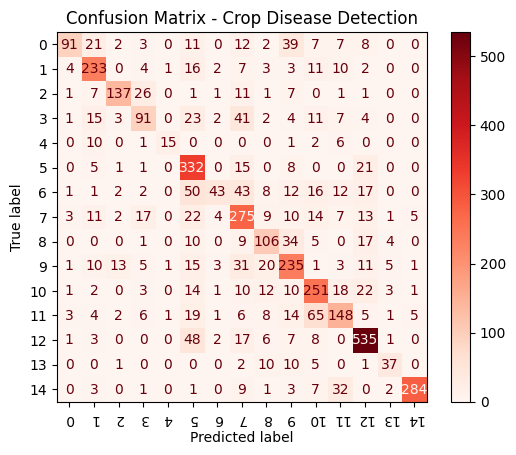

In [12]:


model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1) 

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=180)
plt.title("Confusion Matrix - Crop Disease Detection")
plt.show()


Classification Report (Precision, Recall, F1-score per class):

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.84      0.38      0.53       203
                     Pepper__bell___healthy       0.68      0.77      0.72       296
                      Potato___Early_blight       0.80      0.70      0.75       194
                       Potato___Late_blight       0.63      0.48      0.54       204
                           Potato___healthy       0.72      0.37      0.49        35
                      Tomato_Bacterial_spot       0.60      0.86      0.71       383
                        Tomato_Early_blight       0.64      0.16      0.26       207
                         Tomato_Late_blight       0.56      0.70      0.62       393
                           Tomato_Leaf_Mold       0.58      0.58      0.58       186
                  Tomato_Septoria_leaf_spot       0.52      0.59      0.55       355


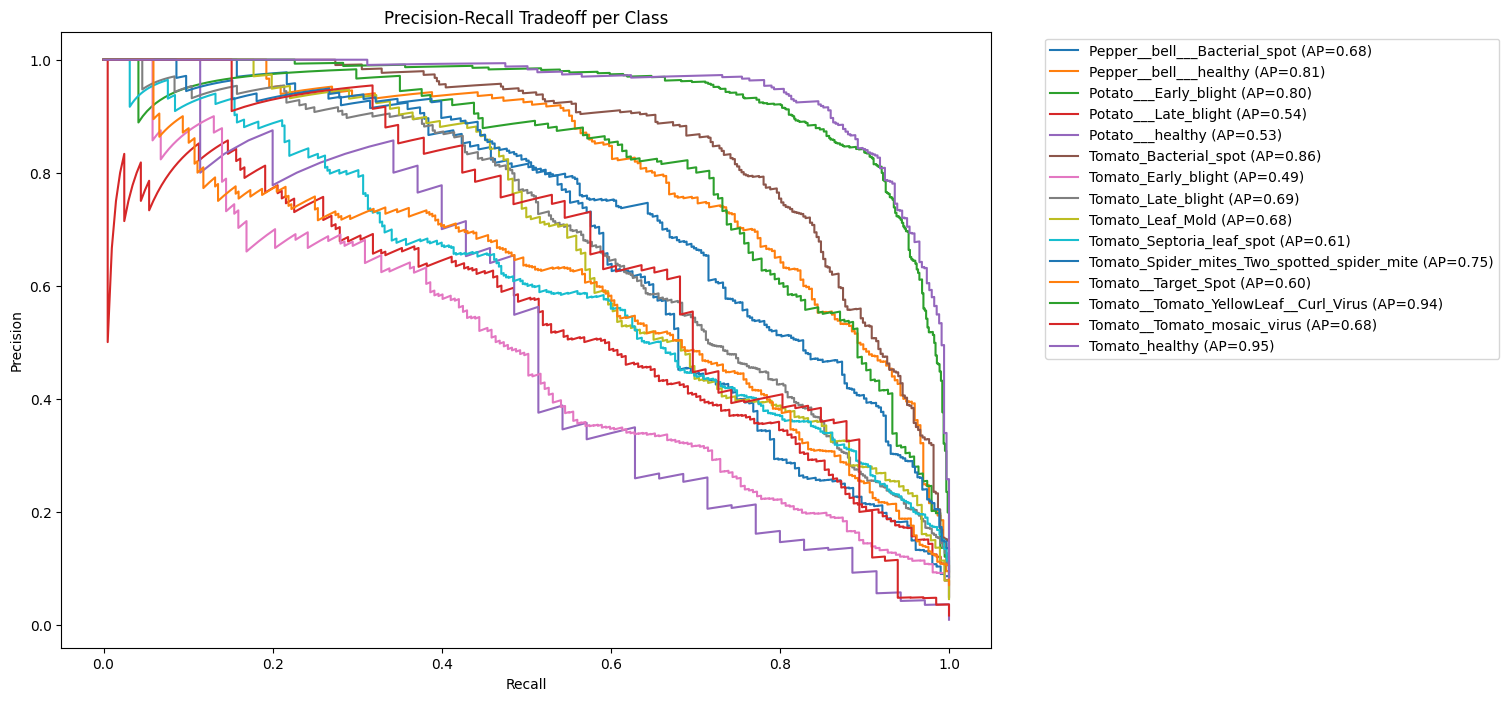

In [13]:



model.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) 
        probs = F.softmax(outputs, dim=1) 

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)


y_pred = np.argmax(y_scores, axis=1)
report = classification_report(y_true, y_pred, target_names=dataset.classes)
print("Classification Report (Precision, Recall, F1-score per class):\n")
print(report)

n_classes = y_scores.shape[1]
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_true == i, y_scores[:, i])
    ap = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f'{dataset.classes[i]} (AP={ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Tradeoff per Class")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()
